In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from   scipy import special
from   scipy import integrate
import emcee
import corner

In [4]:
C_fuv = 43.35                    # SFR to log(FUV_lumin)
mab0  = -2.5*np.log10(3631e-23)  # AB Mag zero pt
pccm  = 3.086e18                 # pc->cm conversion
c     = 2.99792458e18            # Ang/s

# Data

Data for fitting the Schechter function has been taken from Bouwens et al (2015). The magnitudes given are absolute magnitudes in the AB system.

### z = 4

In [4]:
Mz4 = np.linspace(-22.69,-17.69,endpoint=True,num=11)
Mz4 = np.append(Mz4,[-16.94,-15.94])
phiz4 = np.array([3, 15, 134, 393, 678, 1696, 2475, 2984, 5352, 6865,
                  10473, 24580, 25080])*1e-6
errz4 = np.array([4,  9,  23,  40,  63,  113,  185,  255,  446, 1043,
                   2229,  3500,  7860])*1e-6

### z = 6

In [5]:
Mz6 = np.linspace(-22.52,-19.52,endpoint=True,num=7)
Mz6 = np.append(Mz6,[-18.77,-17.77,-16.77])
phiz6 = np.array([2, 15, 53, 176, 320, 698, 1246, 1900, 6680, 13640])*1e-6
errz6 = np.array([2,  6, 12,  25,  41,  83,  137,  320, 1380,  4200])*1e-6

### z = 8

In [5]:
Mz8 = np.linspace(-22.87,-19.37,endpoint=True,num=8)
Mz8 = np.append(Mz8,[-18.62,-17.62])
phiz8 = np.array([0, 0, 5, 13, 58, 60, 331, 533, 1060, 2740])*1e-6
errz8 = np.array([2, 2, 3,  5, 15, 26, 104, 226,  340, 1040])*1e-6

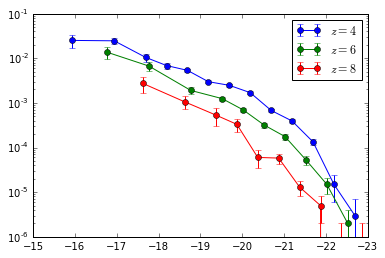

In [8]:
fig,ax= plt.subplots(1,1)
ax.set_yscale("log", nonposy='clip')
ax.errorbar(Mz4, phiz4, yerr=errz4, fmt='o-',label=r'$z=4$' )
ax.errorbar(Mz6, phiz6, yerr=errz6, fmt='o-',label=r'$z=6$' )
ax.errorbar(Mz8, phiz8, yerr=errz8, fmt='o-',label=r'$z=8$' )
ax.invert_xaxis()
ax.legend()

In [9]:
def lnprior(theta):
    if (1e-5<theta[0]<1e-1) & (-22<theta[1]<-15) & (-2<theta[2]<0):
        return 0.0
    return -np.inf

In [10]:
def lnP(theta,M,phi,err):
    """ theta=(phi*, M*, alpha)"""
    lp = lnprior(theta)
    if not(np.isfinite(lp)):
        return -np.inf    
    phi_pred = 0.4*np.log(10)*theta[0]*np.power(10,0.4*(theta[2]+1)*(theta[1]-M))*np.exp(-np.power(10,0.4*(theta[1]-M)))
    chi2 = np.sum(((phi-phi_pred)/err)**2)/2
    return -chi2

In [11]:
ndim,nwalkers=3,300
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnP,args=(Mz4,phiz4,errz4))

theta0 = np.array([np.random.rand(ndim) for i in range(nwalkers)])
theta0[:,0] = (phiz4.max()-phiz4.min())*theta0[:,1]+phiz4.min()
theta0[:,1] = (22-15)*theta0[:,1]-22
theta0[:,2] = 2*theta0[:,2]-2

In [12]:
pos, prob, state = sampler.run_mcmc(theta0,1500)
sampler.reset()

sampler.run_mcmc(pos,500)

(array([[  1.71994946e-03,  -2.08522261e+01,  -1.65474938e+00],
        [  1.61278031e-03,  -2.09053669e+01,  -1.66163161e+00],
        [  2.03167768e-03,  -2.07693650e+01,  -1.63840775e+00],
        [  1.73803433e-03,  -2.08933162e+01,  -1.66663255e+00],
        [  1.94150764e-03,  -2.07677958e+01,  -1.61980846e+00],
        [  1.51827841e-03,  -2.09480530e+01,  -1.71291113e+00],
        [  1.48406441e-03,  -2.09605719e+01,  -1.68032134e+00],
        [  1.80996764e-03,  -2.08961586e+01,  -1.59430671e+00],
        [  2.00050642e-03,  -2.07829485e+01,  -1.59938945e+00],
        [  1.56864987e-03,  -2.09571026e+01,  -1.67823071e+00],
        [  1.95350937e-03,  -2.08059401e+01,  -1.61532915e+00],
        [  1.83863716e-03,  -2.08325898e+01,  -1.65192392e+00],
        [  2.44152459e-03,  -2.06494994e+01,  -1.51680215e+00],
        [  1.48639800e-03,  -2.10284707e+01,  -1.66905311e+00],
        [  1.87417971e-03,  -2.08545800e+01,  -1.57953023e+00],
        [  1.77917606e-03,  -2.09021168e

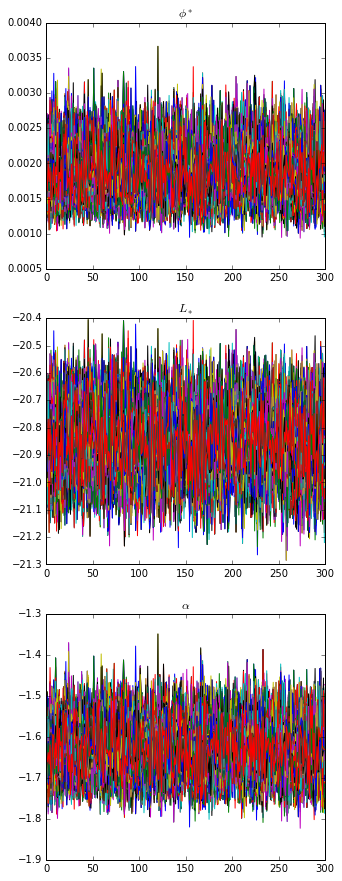

In [13]:
## Diagnostic plots
f1,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(5,15))
ax1.plot(sampler.chain[:,:,0])
ax1.set_title(r'$\phi^*$')
ax2.plot(sampler.chain[:,:,1])
ax2.set_title(r'$L_*$')
ax3.plot(sampler.chain[:,:,2])
ax3.set_title(r'$\alpha$')

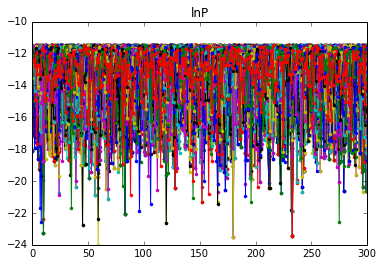

In [14]:
f2,ax4=plt.subplots(1,1)
ax4.plot(sampler.lnprobability,'.-')
ax4.set_title(r'lnP')

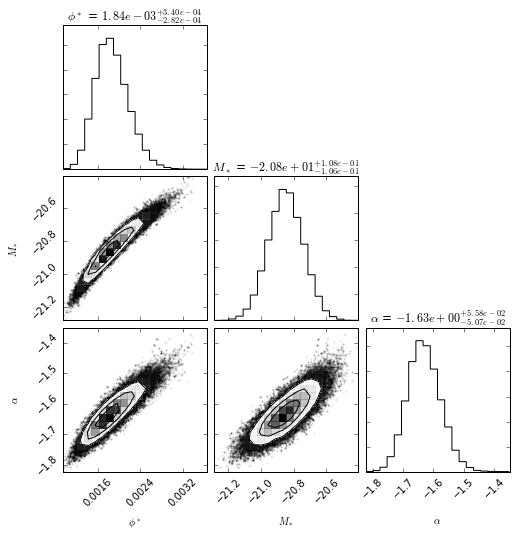

In [19]:
## Corner plot
crnr = corner.corner(sampler.flatchain,labels=(r'$\phi^*$',r'$M_*$',r'$\alpha$'),show_titles=True,
                     title_fmt='.2e',fontsize=24)

In [21]:
phi_star = np.percentile(sampler.flatchain[:,0],50)
M_star = np.percentile(sampler.flatchain[:,1],50)
alpha = np.percentile(sampler.flatchain[:,2],50)

phi_pred = (np.log(10)/2.5)*phi_star*np.power(10,0.4*(M_star-Mz4)*(alpha+1))*np.exp(-np.power(10,0.4*(M_star-Mz4)))

print("Final values for z=4: phi* = %.2e    alpha = %.2f    M*=%.2f"%(phi_star,alpha,M_star))

Final values for z=4: phi* = 1.84e-03    alpha = -1.63    M*=-20.85


# z=4

For this redshift, the best fit Schechter parameters with the reported values are:

|Parameter | Best Fit Value | Bouwens+15 |
|----------|:--------:|:---------------:|
| $\phi_*$ |$1.84 \times 10^{-3}$ | $1.97 \times 10^{-3}$ |
| $M_*$    | -20.85   | -20.88 |
| $\alpha$ | -1.63    | -1.64  |

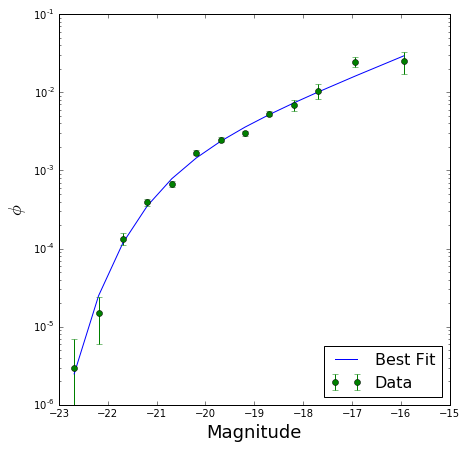

In [26]:
f3,ax5 = plt.subplots(1,1,figsize=(7,7))
ax5.set_yscale("log", nonposy='clip')
ax5.plot(Mz4,phi_pred,'-',label='Best Fit')
ax5.errorbar(Mz4,phiz4,yerr=errz4,fmt='o',label='Data')
ax5.set_xlabel('Magnitude',fontsize=18)
ax5.set_ylabel(r'$\phi$',fontsize=18)
ax5.legend(loc=4,fontsize=16)

In [47]:
def lnprior(theta):
    if (1e-6<theta[0]<1e-1) & (-23<theta[1]<-15) & (-3<theta[2]<0):
        return 0.0
    return -np.inf

def lnP(theta,M,phi,err):
    """ theta=(phi*, M*, alpha)"""
    lp = lnprior(theta)
    if not(np.isfinite(lp)):
        return -np.inf    
    phi_pred = 0.4*np.log(10)*theta[0]*np.power(10,0.4*(theta[2]+1)*(theta[1]-M))*np.exp(-np.power(10,0.4*(theta[1]-M)))
    chi2 = np.sum(((phi-phi_pred)/err)**2)/2
    return -chi2

In [48]:
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnP,args=(Mz6,phiz6,errz6))

theta0 = np.array([np.random.rand(ndim) for i in range(nwalkers)])
theta0[:,0] = (phiz6.max()-phiz6.min())*theta0[:,1]+phiz6.min()
theta0[:,1] = (23-15)*theta0[:,1]-23
theta0[:,2] = 2*theta0[:,2]-2

In [49]:
pos, prob, state = sampler.run_mcmc(theta0,1500)
sampler.reset()

sampler.run_mcmc(pos,500)

(array([[  6.13311915e-04,  -2.08882571e+01,  -1.83839230e+00],
        [  1.19716675e-03,  -2.05249628e+01,  -1.60973791e+00],
        [  2.84152801e-04,  -2.13178987e+01,  -1.99699843e+00],
        [  5.84821837e-04,  -2.08817134e+01,  -1.80214749e+00],
        [  5.45804191e-04,  -2.09425877e+01,  -1.84838979e+00],
        [  6.48992052e-04,  -2.08920156e+01,  -1.73833494e+00],
        [  5.86352545e-04,  -2.08860895e+01,  -1.79853470e+00],
        [  1.40302186e-05,  -2.29998138e+01,  -2.32643552e+00],
        [  2.30994520e-05,  -2.26613687e+01,  -2.31037711e+00],
        [  8.94180696e-04,  -2.07100862e+01,  -1.69947787e+00],
        [  2.37743545e-05,  -2.26167083e+01,  -2.28998409e+00],
        [  6.48733400e-04,  -2.08367757e+01,  -1.83079546e+00],
        [  5.18590334e-04,  -2.10256183e+01,  -1.78489627e+00],
        [  6.17505298e-04,  -2.08396035e+01,  -1.80753520e+00],
        [  7.56371495e-04,  -2.07574999e+01,  -1.69392213e+00],
        [  3.42550302e-05,  -2.24715041e

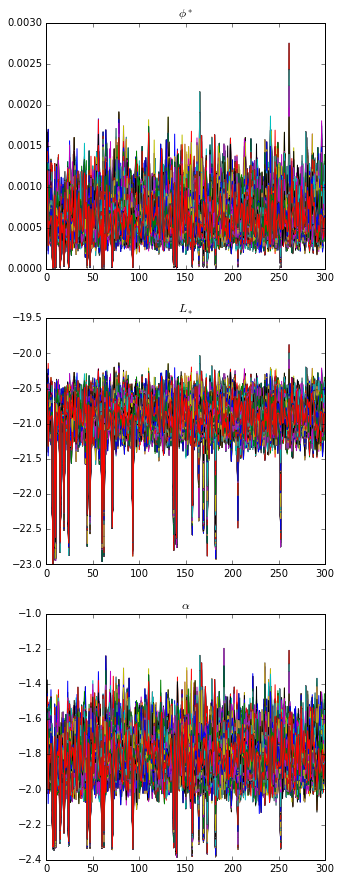

In [50]:
## Diagnostic plots
f1,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(5,15))
ax1.plot(sampler.chain[:,:,0])
ax1.set_title(r'$\phi^*$')
ax2.plot(sampler.chain[:,:,1])
ax2.set_title(r'$L_*$')
ax3.plot(sampler.chain[:,:,2])
ax3.set_title(r'$\alpha$')

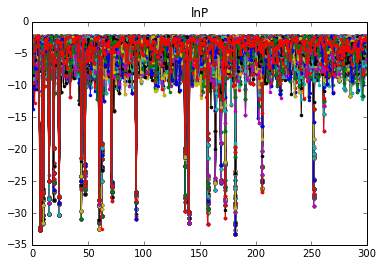

In [51]:
f2,ax4=plt.subplots(1,1)
ax4.plot(sampler.lnprobability,'.-')
ax4.set_title(r'lnP')

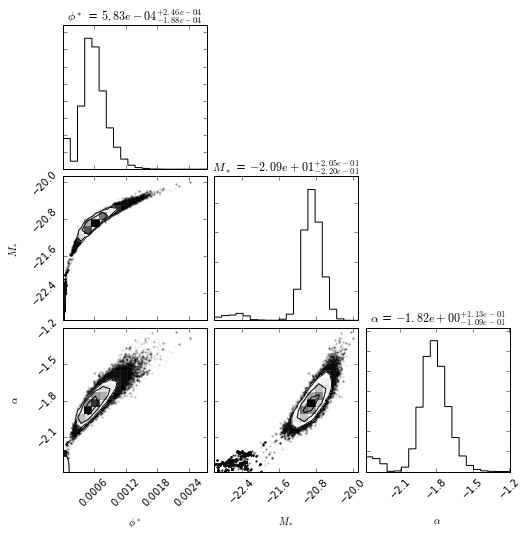

In [52]:
## Corner plot
crnr = corner.corner(sampler.flatchain,labels=(r'$\phi^*$',r'$M_*$',r'$\alpha$'),show_titles=True,
                     title_fmt='.2e',fontsize=24)

# z = 6

For this redshift, the best fit values and the values reported by Bouwens et. al. (2015) are given below.

|Parameter | Best Fit Value | Bouwens+15 |
|----------|:--------:|:----------:|
| $\phi_*$ |$5.92 \times 10^{-4}$ | $5 \times 10^{-4}$ |
| $M_*$    | -20.88   | -20.94 |
| $\alpha$ | -1.82    | -1.87  |

Final values for z=6: phi* = 5.83e-04    alpha = -1.82    M*=-20.89


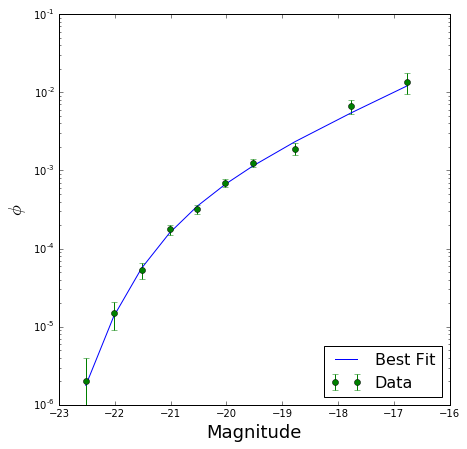

In [53]:
phi_star = np.percentile(sampler.flatchain[:,0],50)
M_star = np.percentile(sampler.flatchain[:,1],50)
alpha = np.percentile(sampler.flatchain[:,2],50)

phi_pred = (np.log(10)/2.5)*phi_star*np.power(10,0.4*(M_star-Mz6)*(alpha+1))*np.exp(-np.power(10,0.4*(M_star-Mz6)))

print("Final values for z=6: phi* = %.2e    alpha = %.2f    M*=%.2f"%(phi_star,alpha,M_star))

f3,ax5 = plt.subplots(1,1,figsize=(7,7))
ax5.set_yscale("log", nonposy='clip')
ax5.plot(Mz6,phi_pred,'-',label='Best Fit')
ax5.errorbar(Mz6,phiz6,yerr=errz6,fmt='o',label='Data')
ax5.set_xlabel('Magnitude',fontsize=18)
ax5.set_ylabel(r'$\phi$',fontsize=18)
ax5.legend(loc=4,fontsize=16)

In [6]:
def lnprior(theta):
    if (1e-8<theta[0]<1e-1) & (-23<theta[1]<-15) & (-3<theta[2]<0):
        return 0.0
    return -np.inf

def lnP(theta,M,phi,err):
    """ theta=(phi*, M*, alpha)"""
    lp = lnprior(theta)
    if not(np.isfinite(lp)):
        return -np.inf    
    phi_pred = 0.4*np.log(10)*theta[0]*np.power(10,0.4*(theta[2]+1)*(theta[1]-M))*np.exp(-np.power(10,0.4*(theta[1]-M)))
    chi2 = np.sum(((phi-phi_pred)/err)**2)/2
    return -chi2

In [8]:
ndim,nwalkers=3,300
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnP,args=(Mz8[2:],phiz8[2:],errz8[2:]))

theta0 = np.array([np.random.rand(ndim) for i in range(nwalkers)])
theta0[:,0] = (phiz8.max()-phiz8.min())*theta0[:,1]+phiz8.min()
theta0[:,1] = (23-15)*theta0[:,1]-23
theta0[:,2] = 2*theta0[:,2]-2

In [9]:
pos, prob, state = sampler.run_mcmc(theta0,1500)
sampler.reset()

sampler.run_mcmc(pos,500)

(array([[  5.58201727e-05,  -2.14447067e+01,  -2.20387311e+00],
        [  3.96443011e-04,  -2.03707085e+01,  -1.65817751e+00],
        [  2.10394127e-04,  -2.05197446e+01,  -2.14491911e+00],
        [  2.96811084e-04,  -2.04512916e+01,  -1.70072256e+00],
        [  4.77185399e-04,  -2.00616353e+01,  -1.74823972e+00],
        [  2.59902320e-04,  -2.04441384e+01,  -1.73759086e+00],
        [  4.25122487e-04,  -2.03317187e+01,  -1.85102704e+00],
        [  1.81540332e-04,  -2.04349656e+01,  -2.08205335e+00],
        [  8.49173431e-04,  -1.98530200e+01,  -1.66203078e+00],
        [  1.09375220e-04,  -2.09443523e+01,  -2.14470905e+00],
        [  5.40538769e-05,  -2.11772407e+01,  -2.35906075e+00],
        [  9.25593592e-05,  -2.10007207e+01,  -2.08907073e+00],
        [  2.21670351e-05,  -2.17373902e+01,  -2.35418546e+00],
        [  1.61296964e-04,  -2.08199847e+01,  -1.89182456e+00],
        [  1.76898191e-04,  -2.07517416e+01,  -2.01043197e+00],
        [  4.24672683e-04,  -2.03222807e

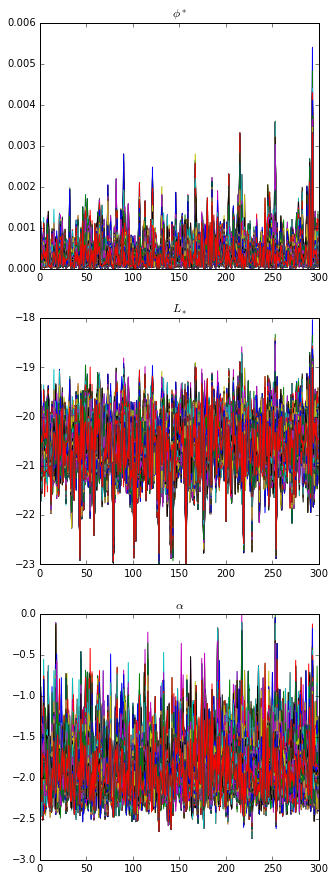

In [10]:
## Diagnostic plots
f1,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(5,15))
ax1.plot(sampler.chain[:,:,0])
ax1.set_title(r'$\phi^*$')
ax2.plot(sampler.chain[:,:,1])
ax2.set_title(r'$L_*$')
ax3.plot(sampler.chain[:,:,2])
ax3.set_title(r'$\alpha$')

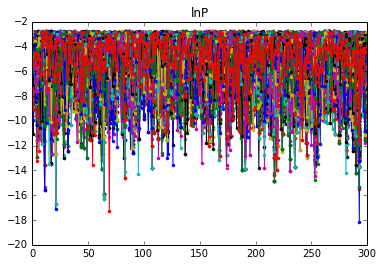

In [11]:
f2,ax4=plt.subplots(1,1)
ax4.plot(sampler.lnprobability,'.-')
ax4.set_title(r'lnP')

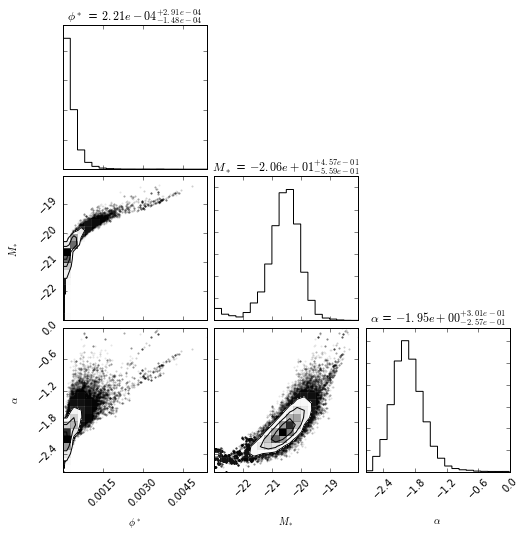

In [12]:
## Corner plot
crnr = corner.corner(sampler.flatchain,labels=(r'$\phi^*$',r'$M_*$',r'$\alpha$'),show_titles=True,
                     title_fmt='.2e',fontsize=24)

Final values for z=8: phi* = 2.21e-04    alpha = -1.95    M*=-20.57


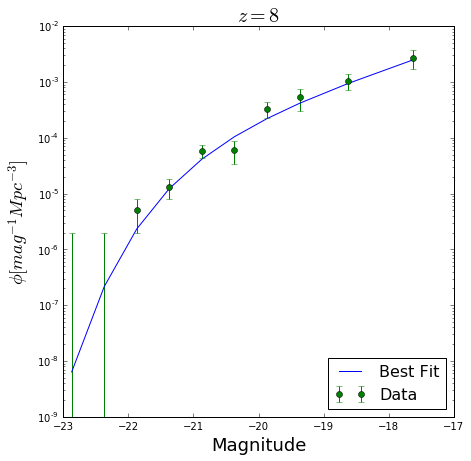

In [17]:
phi_star = np.percentile(sampler.flatchain[:,0],50)
M_star = np.percentile(sampler.flatchain[:,1],50)
alpha = np.percentile(sampler.flatchain[:,2],50)

phi_pred = (np.log(10)/2.5)*phi_star*np.power(10,0.4*(M_star-Mz8)*(alpha+1))*np.exp(-np.power(10,0.4*(M_star-Mz8)))

print("Final values for z=8: phi* = %.2e    alpha = %.2f    M*=%.2f"%(phi_star,alpha,M_star))

f3,ax5 = plt.subplots(1,1,figsize=(7,7))
ax5.set_yscale("log", nonposy='clip')
ax5.plot(Mz8,phi_pred,'-',label='Best Fit')
ax5.errorbar(Mz8,phiz8,yerr=errz8,fmt='o',label='Data')
ax5.set_xlabel('Magnitude',fontsize=18)
ax5.set_ylabel(r'$\phi [mag^{-1} Mpc^{-3}]$',fontsize=18)
ax5.set_title('$z = 8$',fontsize=20)
ax5.legend(loc=4,fontsize=16)

# z = 8

A comparision between the best fit values and the values reported by Bouwens et. al. (2015) is shown below.

|Parameter | Best Fit Value | Bouwens+15 |
|----------|:--------:|:----------:|
| $\phi_*$ |$2.21 \times 10^{-4}$ | $2.1 \times 10^{-4}$ |
| $M_*$    | -20.57   | -20.63 |
| $\alpha$ | -1.95    | -2.02  |

## Comparision:

For all three redshifts, the estimated parameters from the best fit were close to the actual values reported by Bouwens et al (2015). The discrepancy might be due to assuming that the inferred magnitude had no dependence on z. In a magnitude limited sample, it is possible that the correlation between absolute magnitude and redshift (which is higher for higher redshifts), contaminated our estimates. To account for this, Bouwens et. al. used the STY79 method to infer the Schecter function fits from the data. A simple MCMC modelling of the parameters at each redshift may not alleviate the problem easily.